### Pendahuluan

Feature Engineering adalah proses dimana kita menerapkan pengetahuan yang kita punya untuk mendapatkan informasi yang lebih dari data yang kita punya. Contohnya dari KTP seseorang, anda sebenarnya dapat mendapatkan domisili, pembuatan KTP, tanggal lahir, usia, dan jenis kelamin. Anda dapat menggolongkan orang-orang dengan kategori yang sama untuk membuat machine learning lebih mudah membedakan ciri orang.


Di pembahasan kali ini saya menggunakan dataset titanic yang sangat terkenal dan sering digunakan. Dataset ini berasal dari Kaggle, salah satu situs kompetisi machine learning. Dataset ini terdiri dari 2 file, titanic_train.csv dan titanic_test.csv.

Import library python biasanya dilakukan di awal sebuah projek. Library yang kita akan gunakan antara lain:

- pandas untuk proses dataframe dan csv
- matplotlib untuk plotting grafik
- seaborn untuk plotting grafik
- sklearn untuk machine learning model
- string untuk proses string

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Dataset ini adalah dataset Titanic asli yang didapatkan dari Kaggle. Berisi data dari semua orang yang ikut di dalam Kapal Titanic ratusan tahun yang lalu.

Jadi, di dalam dataset ini kita mempunyai target variable/label yaitu Survived. Semua kolom/fitur lain akan digunakan untuk menentukkan apakah penumpang ini selamat/tidak dari kejadian Titanic.

Data Train digunakan untuk melatih model machine learning kita. Data Test nantinya digunakan untuk menebak akurasi model kita di Kaggle.

Pada penjelasan ini teman-teman akan dijelakan untuk melakukan membaca data dari file csv dan melakukan concat dataframe dengan membuat sebuah fungsi.


In [2]:
# 1. Buat Function concat_df digunakan untuk menggabungkan dua dataset/dataframe dari 2 csv menjadi satu dataframe
def concat_df(train_data, test_data):
	#Return a concatenated df of training and test set
	return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

# 2. Untuk memasukkan csv ke dalam Pandas Dataframe, kita harus menggunakan pd.read_csv()
# Data train kita masukkan ke df_train dan Data test kita masukkan ke df_test. df_all adalah gabungan dari kedua dataframe.
df_train = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/challenge/feature-engineering/titanic_train.csv')
df_test = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/challenge/feature-engineering/titanic_test.csv')
df_all = concat_df(df_train, df_test)

# 3. Kita dapat menamai tiap dataframe dengan memberikan "name" untuk masing-masing dataframe dengan cara
df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set'

# 4. dfs adalah list yang berisi kedua dataframe.
dfs = [df_train, df_test]

### Penjelasan Data Frame
- PassengerId adalah id pada row, maka tidak ada pengaruh terhadap target yang dicari
- Survived adalah target yang akan diprediksi, nilai 0 = Not Survived dan nilai 1 = Survived
- Pclass (Passenger Class) adalah kategori level sosial ekonomi penumpang dengan nilai (1, 2 atau 3):
    - 1 = Upper Class
    - 2 = Middle Class
    - 3 = Lower Class
- Name, Sex dan Age merupakan data self-explanatory
- SibSp adalah jumlah saudara dari penumpang
- Parch adalah jumlah Orang Tua dan anak dari penumpang
- Ticket adalah jumlah tiket penumpang
- Fare adalah tarif yang di kenakan kepada penumpang
- Cabin adalah nomor kabin penumpang
- Embarked adalah pelabuhan pemberangkatan ada 3 pelabuhan (C, Q atau S):
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton

### Exploring Data

In [3]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### Mendapatkan Missing Value dan Contoh Data

In [4]:
df_train.info(memory_usage=False)
df_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Mengetahui Korelasi Fitur

In [5]:
df_train_corr = df_train.corr().abs()
print(df_train_corr.to_string())

             PassengerId  Survived    Pclass       Age     SibSp     Parch      Fare
PassengerId     1.000000  0.005007  0.035144  0.036847  0.057527  0.001652  0.012658
Survived        0.005007  1.000000  0.338481  0.077221  0.035322  0.081629  0.257307
Pclass          0.035144  0.338481  1.000000  0.369226  0.083081  0.018443  0.549500
Age             0.036847  0.077221  0.369226  1.000000  0.308247  0.189119  0.096067
SibSp           0.057527  0.035322  0.083081  0.308247  1.000000  0.414838  0.159651
Parch           0.001652  0.081629  0.018443  0.189119  0.414838  1.000000  0.216225
Fare            0.012658  0.257307  0.549500  0.096067  0.159651  0.216225  1.000000


Apabila Anda melihat table, Anda akan mengetahui korelasi antar kolom. Korelasi dapat ditentukan dengan mendekati nilai 1 untuk korelasi positive dan nilai -1 untuk korelasi terbalik.

Pada data ini dapat dilihat bahwa target variable kita Survived sangat besar korelasinya dengan Pclass dan Fare. Sedangkan Age sangat berkaitan dengan Pclass, Sibling Spouse (SibSp), Parent Children (Parch).

Dapat diasumsikan bahwa kebanyakan orang yang selamat adalah orang dengan PClass atas dan Tuanya umur seseorang dapat dikatakan dia akan membawa saudara/orang tua/anak/pasangan.

Dan Fare (harga) tentu saja berkaitan dengan Pclass (kelas penumpang) seorang penumpang.

### Mengenali Missing Data dari Kolom

Dari hasil tersebut ada beberapa kolom masih terdapat nilai kosong seperti age, cabin, embarked pada dataframe training set.


In [6]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




### Mencari Nilai Untuk Missing Value

Untuk mengisi data Age yang kosong, karena kita mengetahui bahwa Umur seseorang berkaitan dengan Kelas penumpangnya, kita dapat mengisinya dengan nilai tengah umur seseorang di dalam kelas tersebut dan berdasar jenis kelaminnya.

Jadi kita lakukan groupby terhadap Jenis Kelamin dan Kelas Penumpang, lalu isi nilai tersebut ke dalam missing value yang ada di dalam data kita.

In [7]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
	for sex in ['female', 'male']:
		print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

#filling missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x .fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


### Mengisi Nilai Kosong

Kita juga harus mengisi nilai yang hilang untuk kolom Embarked dan Fare.

Untuk Embarked, kebanyakan orang dari Titanic berangkat dari Southampton/S, sehingga kita dapat mengisinya dengan S saja. Ini lebih baik daripada membiarkan datanya kosong.

Untuk Fare, kita tahu bahwa Fare sangat berkaitan dengan Kelas Penumpang, Jumlah Parent/Children, dan Jumlah Sibling/Spouse. Sehingga kita dapat mengisinya dengan nilai tengah dari orang yang berada di grup tersebut.

In [8]:
# Filling missing values in Embarked with S
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
df_all['Embarked'] = df_all['Embarked'].fillna('S')

med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

In [9]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1309 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1309 non-null   object 
 3   Fare         1309 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### Exploring Data

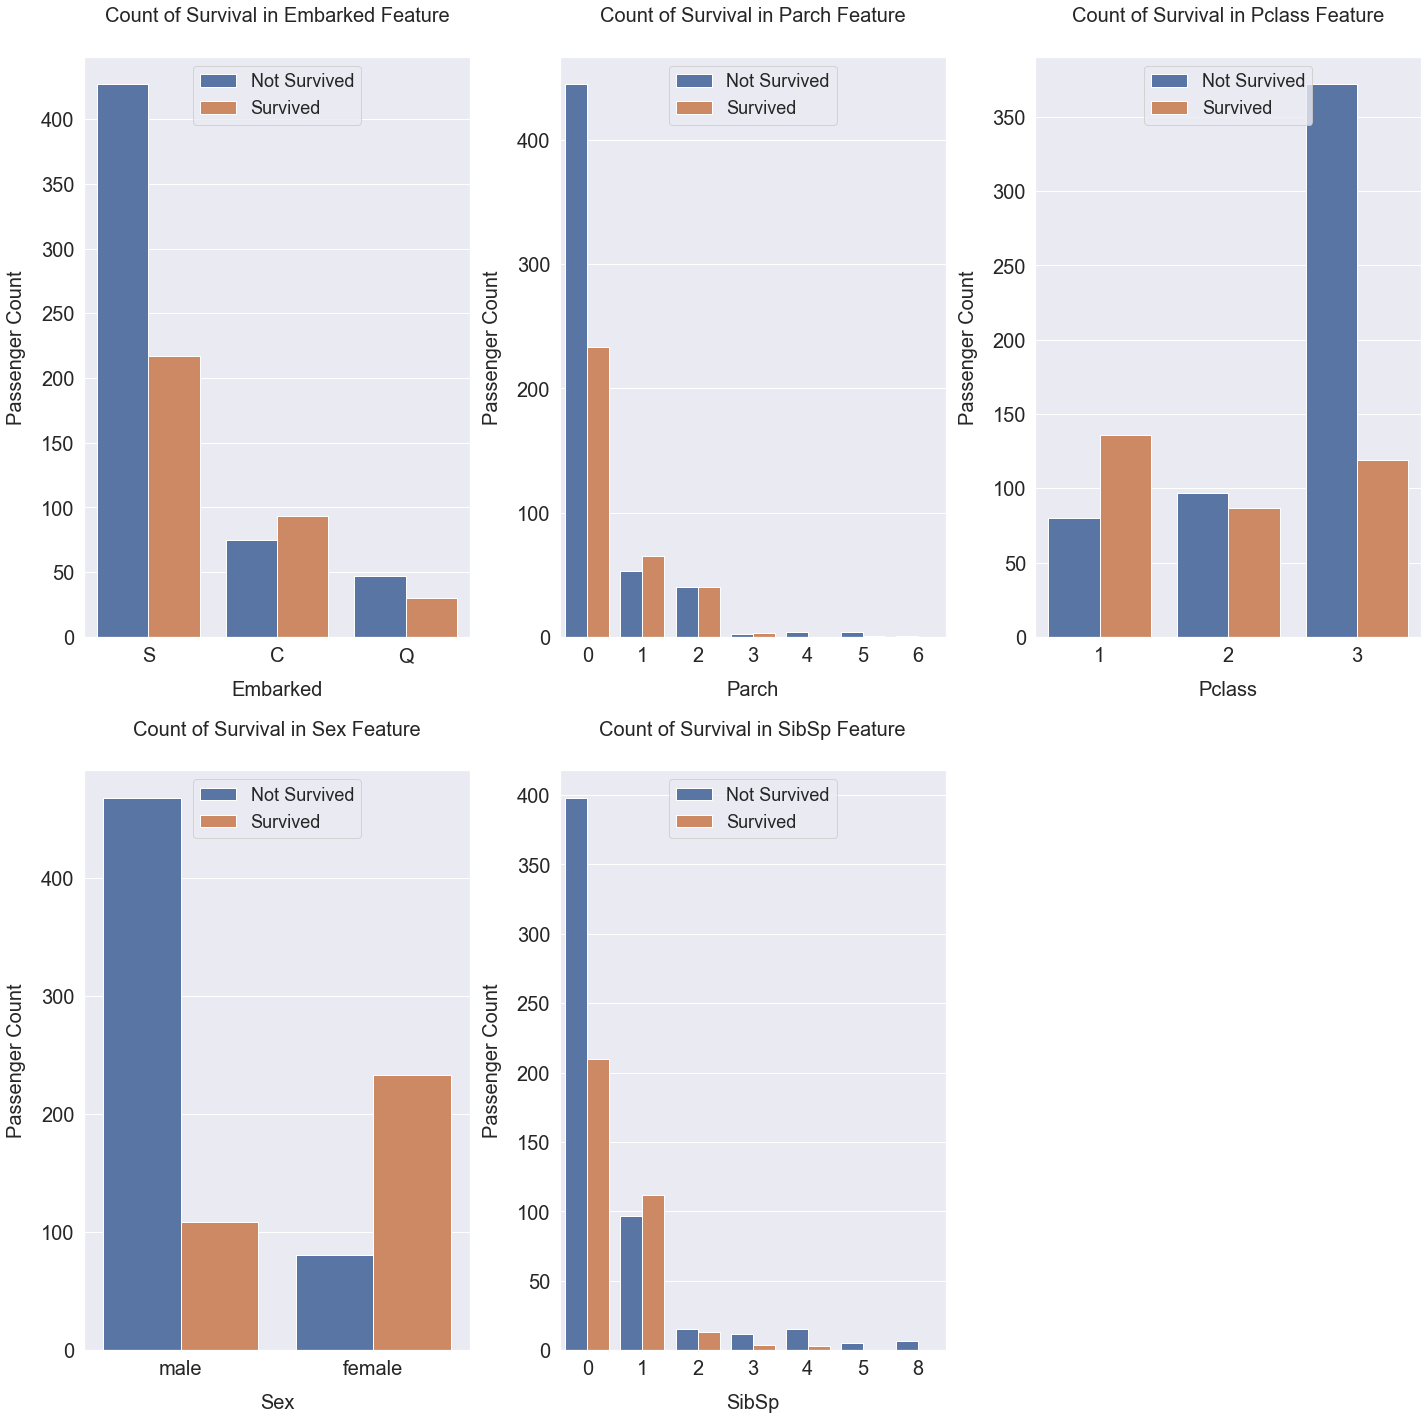

In [10]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):
	plt.subplot(2, 3, i)
	sns.countplot(x=feature, hue='Survived', data=df_train)
	
	plt.xlabel('{}'.format(feature), size=20, labelpad=15)
	plt.ylabel('Passenger Count', size=20, labelpad=15)
	plt.tick_params(axis='x', labelsize=20)
	plt.tick_params(axis='y', labelsize=20)
	
	plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size':18})
	plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)
	
plt.tight_layout()
plt.show()

Dari plot yang dihasikan kita dapat melihat, ternyata penumpang yang berangkat dari Cherbourg lebih banyak yang selamat, sedangkan penumpang dari Southampton, hanya setengahnya yang selamat.

Untuk orang yang membawa hanya 1 Parent/Children, lebih banyak yang selamat.

Untuk orang dengan Kelas Penumpang 1, kemungkinan selamatnya jauh lebih tinggi. Dan penumpang dengan Kelas Penumpang 3 hanya sedikit yang selamat.

Dan Orang yang membawa 1 Sibling/Spouse kemungkinan selamatnya jauh lebih besar.

Orang yang membawa 2 Sibling/Spouse kemungkinan selamatnya cukup kecil.

### Exploring Data 2

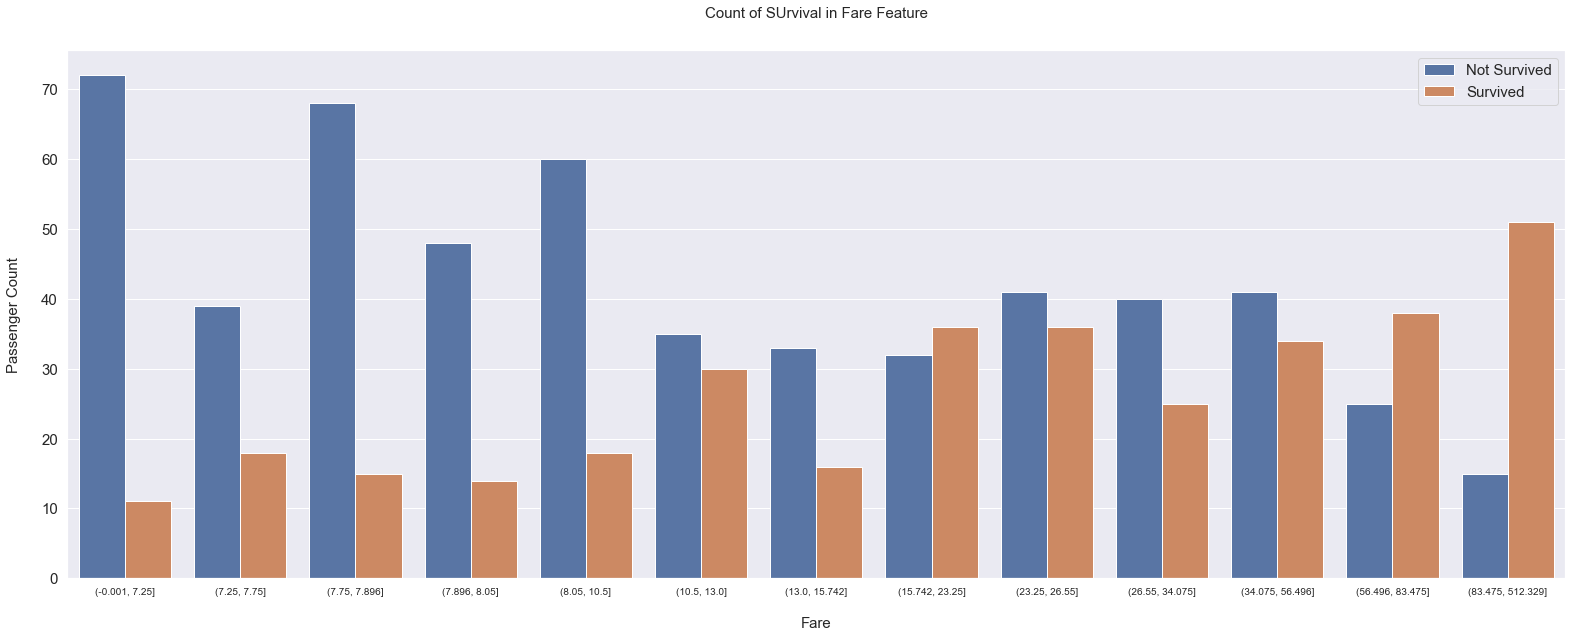

In [11]:
import pandas as pd
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size':15})
plt.title('Count of SUrvival in {} Feature'.format('Fare'), size=15, y=1.05)
plt.tight_layout()
plt.show()

Untuk Data Fare dan Age, kita akan membaginya ke dalam beberapa Bin/Group.

Dari fungsi describe sebelumnya, kita tahu bahwa minimal usia yang ada adalah 0.17 tahun dan yang tertua adalah 80 tahun. Sehingga saya rasa membaginya dengan 13 kelompok quantile cukup.

Dan untuk Fare termurah adalah 0 dan termahal adalah 512 (lihat hasil statistik dekriptifnya). Sehingga saya rasa membaginya dengan 10 kelompok quantile cukup.

Perintah yang pertama bermaksud untuk membagi Fare menjadi 13 bagian dengan fungsi qcut().

Dan perintah yang kedua adalah untuk menggambarkan plot group usia terhadap tingkat keselamatan.

Dapat dilihat bahwa semakin mahal harga tiketnya, semakin besar kemungkinan orang itu selamat, dimulai dari harga 56 ke atas.

Tetapi banyak orang yang selamat dimulai dari 10.5 sudah cukup meningkat, kecuali kejadian yang terjadi pada kelompok pemegang tiket berharga 13-15.742.

 

Note:

Untuk pembagian jumlah bins yang berbeda baik 13 bins untuk "Age" dan 10 bins untuk "Fare" tidak aturan bakunya. Tetapi yang diinginkan dari visualisasi berdasarkan pembagian dengan jumlah bins adalah sebaran datanya. 

Sebagai contoh untuk "Age" yang memiliki range data 0 (min) s/d 80 (max). Untuk itu, awalnya membagi data menjadi 8 bins katakanlah cukup untuk mereprsentasikan sebaran data. Ketika setelah dicek dengan visualisasi sebarannya belum mewakili dan adanya skew. Selanjutnya, kita dapat menaikkan/menurunkan jumlah bins untuk melihat sebaran data berikut. Untuk "Age" ini terpilihlah 13 bins yang cocok untuk mepresentasikan sebaran data. Dengan cara yang sama dapat juga diterapkan untuk "Fare".

Jadi tidak ada aturan baku yang mengatur jumlah bins tersebut.